# Process Historical Fire Perimeters

## Import packages

In [1]:
import geopandas as gpd
import fiona
import os
import zipfile
import rasterio
import numpy as np
from rasterio.features import rasterize
from rasterio.transform import from_origin
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as ctx
import ipywidgets as widgets
from IPython.display import display

## Extract and read in fire perimeter vector data

In [2]:
# File paths
fire_perimeters_zip_path = r"C:\Users\imire\OneDrive - UW\Documents\GDA567\disturbance_interaction_analysis\downloaded_data\historic_fire_perimeters\InterAgencyFirePerimeterHistory_All_Years_View.zip"
output_shp_folder_path = r"C:\Users\imire\OneDrive - UW\Documents\GDA567\disturbance_interaction_analysis\downloaded_data\historic_fire_perimeters"
output_mnf_subset_folder_path = r"C:\Users\imire\OneDrive - UW\Documents\GDA567\disturbance_interaction_analysis\extracted_mnf_subset"
mtbs_points_path = r"C:\Users\imire\OneDrive - UW\Documents\GDA567\disturbance_interaction_analysis\downloaded_data\mtbs\mtbs_fod_pts_data\mtbs_FODpoints_DD.shp"


In [3]:
# Define unzip to output location function
def unzip_folder(zip_path, extract_to): 
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted to: {extract_to}")

In [4]:
unzip_folder(fire_perimeters_zip_path, output_shp_folder_path) # Unzip shp

Extracted to: C:\Users\imire\OneDrive - UW\Documents\GDA567\disturbance_interaction_analysis\downloaded_data\historic_fire_perimeters


In [5]:
fires_gdf = gpd.read_file(output_shp_folder_path + "\\InterAgencyFirePerimeterHistory_All_Years_View.shp")

In [6]:
fires_gdf.head()

,OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,INCIDENT,...,GIS_ACRES,USER_NAME,SOURCE,AGENCY,FIRE_YEAR_,Shape__Are,Shape__Len,FORID,OTHERID,geometry
0,1,Infrared Interpretation,201812200931,None,{F0C1D266-75BB-4CA5-9E6F-F310F5038E23},None,None,2002,None,MISSIONARY RIDGE,...,70480.83,None,USFS,USFS,2002,4.525708e+08,279658.944677,None,None,"MULTIPOLYGON (((-11974175.167 4511483.444, -11..."
1,2,GPS - Uncorrected Data,201812200931,None,{411C4683-1404-4631-B20B-8FD8E73F72C6},None,2012-COSJF-001108,2012,None,COAL CREEK,...,97.68,None,USFS,USFS,2012,6.264264e+05,5170.317870,None,None,"POLYGON ((-11898257.752 4485689.218, -11898245..."
2,3,Digitized-Other,201812200931,None,{FFB2E84B-D807-4F2C-91AC-C50EE9EF702D},None,None,1998,None,TURKEY CREEK WFU,...,308.54,None,USFS,USFS,1998,1.969943e+06,8067.631188,None,None,"POLYGON ((-11957688.186 4465171.969, -11957685..."
3,4,Digitized-Other,201812200931,None,{26F30670-C114-4D34-909E-2751E7B42DC7},None,2011-COSJF-000213,2011,None,WILDHORSE,...,14.87,None,USFS,USFS,2011,9.653684e+04,1265.594810,None,None,"POLYGON ((-12110778.56 4561415.155, -12110786...."
4,5,GPS - Uncorrected Data,201812200931,None,{53630F8B-3263-4442-A60E-5D1A353F04CD},{67132D49-B7F4-4211-8D72-DC2103A1826B},2016-COSJF-000444,2016,None,LONG DRAW,...,2142.83,None,USFS,USFS,2016,1.383778e+07,17001.554406,None,None,"POLYGON ((-12063543.3 4532611.314, -12063516.5..."


## Clean fire perimeter gdf

* Ensure "FIRE_YEAR" is numeric to allow arithmetic operations.
* Remove records associated with invalid years "0", "1", and "9999."
* Check that invalid records were dropped correctly.

In [7]:
# Convert FIRE_YEAR to numeric, handling any errors
fires_gdf["FIRE_YEAR"] = pd.to_numeric(fires_gdf["FIRE_YEAR"], errors = "coerce") # Convert fire year to numeric

# Get unique values as a sorted list
unique_years = sorted(fires_gdf["FIRE_YEAR"].unique()) # List unique values of year

# Exclude records from invalid years
excluded_years = {9999, 1, 0}
valid_incidents = fires_gdf[~fires_gdf["FIRE_YEAR"].isin(excluded_years)].sort_values(by = "FIRE_YEAR", ascending = True)

In [8]:
valid_incidents.head()

,OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,INCIDENT,...,GIS_ACRES,USER_NAME,SOURCE,AGENCY,FIRE_YEAR_,Shape__Are,Shape__Len,FORID,OTHERID,geometry
12447,12448,Other,200611020000,Year burned determined by PNW using carbon dat...,{A526C90F-6DE2-4296-8643-87B34452311C},None,None,780,None,UNNAMED,...,9309.31,None,USFS,USFS,780,8.245466e+07,86883.156264,None,None,"MULTIPOLYGON (((-13754978.274 6026659.244, -13..."
14219,14220,Other,200611020000,Year burned determined by PNW using carbon dat...,{722D984E-DF48-4A96-AFDF-B938E86FE599},None,None,1000,None,UNNAMED,...,0.01,None,USFS,USFS,1000,1.154141e+02,85.096169,None,None,"POLYGON ((-13508198.41 6097117.203, -13508189...."
2631,2632,Other,200611020000,Year burned determined by PNW using carbon dat...,{D83B067C-4385-4237-83D1-77C5DA8C22BA},None,None,1000,None,UNNAMED,...,1505.66,None,USFS,USFS,1000,1.380549e+07,18201.888885,None,None,"POLYGON ((-13483960.982 6170816.394, -13483983..."
2607,2608,Other,200611020000,Year burned determined by PNW using carbon dat...,{F26FA54D-89EF-414A-80F5-7588A37F2A00},None,None,1000,None,UNNAMED,...,129.56,None,USFS,USFS,1000,1.210874e+06,5867.130114,None,None,"POLYGON ((-13551342.83 6253654.238, -13551442...."
2641,2642,Other,200611020000,Year burned determined by PNW using carbon dat...,{92B942E5-4D9D-4610-9961-69B7D512740B},None,None,1000,None,UNNAMED,...,2991.72,None,USFS,USFS,1000,2.718905e+07,31025.996617,None,None,"POLYGON ((-13465336.552 6132079.277, -13465324..."


In [9]:
# Check valid incidents gdf
data_summary = {
    "all_records_count": len(fires_gdf),
    "valid_records_count": len(valid_incidents),
    "first_incident": valid_incidents.iloc[0]["INCIDENT"],
    "first_fire_year": valid_incidents.iloc[0]["FIRE_YEAR"],
    "last_incident": valid_incidents.iloc[-1]["INCIDENT"],
    "last_fire_year": valid_incidents.iloc[-1]["FIRE_YEAR"]
}

summary_text = '''The NIFC Historic Fire Perimeter dataset contains {all_records_count} records of which {valid_records_count} are labeled with a valid year.
The oldest valid record is for the {first_incident} incident {first_fire_year}. 
The newest valid record is for the {last_incident} incident in {last_fire_year}.
'''.format(**data_summary)

print(summary_text)

The NIFC Historic Fire Perimeter dataset contains 116365 records of which 116055 are labeled with a valid year.
The oldest valid record is for the UNNAMED incident 780. 
The newest valid record is for the Oak incident in 2023.



## Prepare to subset fires_gdf

* Extract all perimeters intersecting the boundary of Malheur National Forest (MNF).
* Write perimeter features intersecting MNF to a GeoJSON.

In [10]:
mnf_bounds_gdf = gpd.read_file(r"C:\Users\imire\OneDrive - UW\Documents\GDA567\boundary_geoJSONs\malheur_bounds.geojson") # Read in gdf with Malheur National Forest boundary
mnf_bounds_gdf.columns

Index(['OBJECTID', 'ADMINFORES', 'REGION', 'FORESTNUMB', 'FORESTORGC',
       'FORESTNAME', 'GIS_ACRES', 'SHAPELEN', 'SHAPEAREA', 'geometry'],
      dtype='object')

In [11]:
mnf_bounds_gdf = mnf_bounds_gdf[["FORESTNAME", "geometry"]] # Drop all columns other than FORESTNAME and geometry

In [12]:
# Make sure CRS of mnf_bounds_gdf and fires_gdf are the same
if mnf_bounds_gdf.crs == fires_gdf.crs:
    print("Both datasets are in " + str(mnf_bounds_gdf.crs) + ".")
else:
    print("Datasets are not in same CRS.")

# Both already in Web Mercator

Both datasets are in EPSG:3857.


## Filter fires_gdf to include only fires that overlap the Malheur NF boundary

In [13]:
# Perform spatial join to subset valid fires that overlapped the Malheur NF boundary
mnf_fires_all = gpd.sjoin(valid_incidents, mnf_bounds_gdf, how = "left", predicate = "intersects")
mnf_fires_all = mnf_fires_all[mnf_fires_all["FORESTNAME"] == "Malheur National Forest"].sort_values(by = "FIRE_YEAR", ascending = True)

In [14]:
mnf_fires_all.columns

Index(['OBJECTID', 'MAP_METHOD', 'DATE_CUR', 'COMMENTS', 'GEO_ID', 'IRWINID',
       'UNQE_FIRE_', 'FIRE_YEAR', 'LOCAL_NUM', 'INCIDENT', 'UNIT_ID',
       'POO_RESP_I', 'FEATURE_CA', 'GIS_ACRES', 'USER_NAME', 'SOURCE',
       'AGENCY', 'FIRE_YEAR_', 'Shape__Are', 'Shape__Len', 'FORID', 'OTHERID',
       'geometry', 'index_right', 'FORESTNAME'],
      dtype='object')

In [15]:
mnf_record_count = len(mnf_fires_all)
mnf_first_fire_year = mnf_fires_all.iloc[0]["FIRE_YEAR"]
mnf_first_incident = mnf_fires_all.iloc[0]["INCIDENT"]
mnf_last_fire_year = mnf_fires_all.iloc[-1]["FIRE_YEAR"]
mnf_last_incident = mnf_fires_all.iloc[-1]["INCIDENT"]

In [16]:
# Define the dictionary with string keys
data_summary = {
    "mnf_record_count" :  mnf_record_count,
    "mnf_first_incident": mnf_first_incident,
    "mnf_first_fire_year": mnf_first_fire_year,
    "mnf_last_incident": mnf_last_incident,
    "mnf_last_fire_year": mnf_last_fire_year
}

# Format the text correctly
summary_text = '''The NIFC Historic Fire Perimeter dataset contains {mnf_record_count} valid records of fires with perimeters overlapping the Malneur National Forest boundary.
The oldest record is for the {mnf_first_incident} incident in {mnf_first_fire_year}. 
The newest record is for the {mnf_last_incident} incident in {mnf_last_fire_year}.
'''.format(**data_summary)

# Print the formatted text
print(summary_text)

The NIFC Historic Fire Perimeter dataset contains 216 valid records of fires with perimeters overlapping the Malneur National Forest boundary.
The oldest record is for the 1910 Fire 28 incident in 1910. 
The newest record is for the Lost Spring incident in 2023.



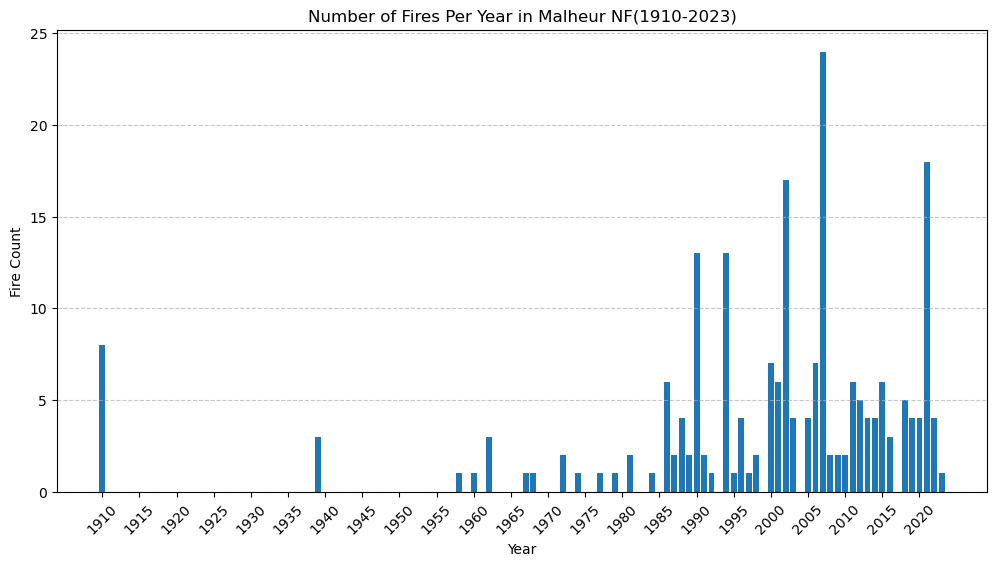

In [17]:
# Group by year and count occurrences
fires_per_year = mnf_fires_all.groupby('FIRE_YEAR').size().reset_index(name = 'count')

year_range = pd.DataFrame({'FIRE_YEAR': range(1910, 2024)})
fires_per_year = year_range.merge(fires_per_year, on="FIRE_YEAR", how="left").fillna(0)
fires_per_year["count"] = fires_per_year["count"].astype(int)

plt.figure(figsize=(12, 6))
plt.bar(fires_per_year["FIRE_YEAR"], fires_per_year["count"])
plt.xlabel("Year")
plt.ylabel("Fire Count")
plt.title("Number of Fires Per Year in Malheur NF(1910-2023)")
tick_positions = np.arange(1910, 2025, 5)  # Every 5 years
plt.xticks(tick_positions, rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

The fires in 1910 and 1939 are well recorded and have sizable overlap with later fires, so they weill be kept in the dataset. However, the absence of records for the intervening years between records, especially prior to the 1950s, should not be assumed to indicate a lack of fire but instead a potential lack of /recorded/ fire. While the larger dataset does include fires going back to the 8th century mapped using carbon dating, there very well may be fires that occured within Malheur that went unrecorded or even unnoticed. While Malheur was designated a National Forest in 1908, it was not exactly a hot destination for recreators at the time. Future studies of historical sources or further investigation of natural markers of fire history (e.g., fire scars, pollen record, soil cores) may reveal unknown fires. 

However, it is also likely that there were in fact few to zero fires in the early 20th century due to the aggressive fire exclusion and suppression approaches to forest management employed by the Forest Service. Ultimately, it may not be possible to ever consider this dataset truly complete or known how close to complete it actually is. That being said, it is a rich source of spatially explicit data that allows us to begin untangling complex interactions between disturbance agents on a landscape. 

C:\Users\imire\AppData\Local\Temp\ipykernel_28084\1764623761.py:24: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color=fill_color, label="Incident Perimeter", alpha=0.6, edgecolor=edge_color),
C:\Users\imire\AppData\Local\Temp\ipykernel_28084\1764623761.py:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color="none", edgecolor=boundary_edge_color, label="Malheur National Forest Boundary", linewidth=2)


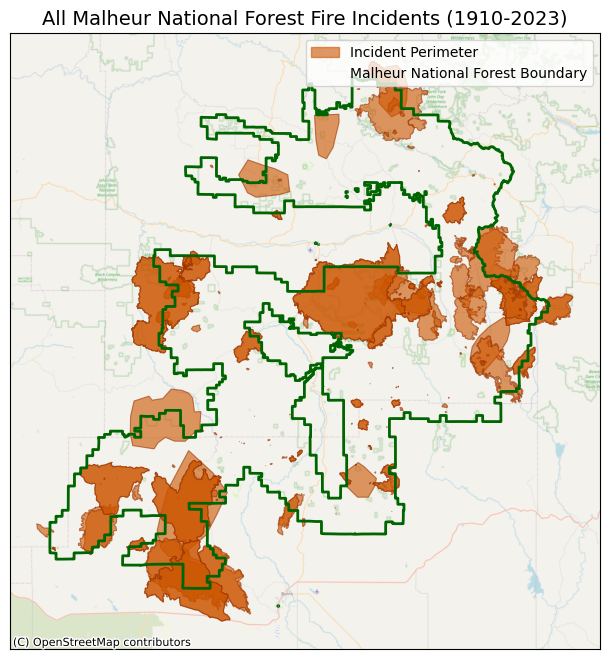

In [18]:
# Define colors
fill_color = "#CC5500"  # Burnt Orange (fire perimeters)
edge_color = "#993300"  # Dark Orange (fire outlines)
boundary_edge_color = "#006400"  # Dark Green (Malheur boundary)

# Ensure GeoDataFrames are in Web Mercator (EPSG:3857) for basemap compatibility
mnf_fires_all = mnf_fires_all.to_crs(epsg=3857)
mnf_bounds_gdf = mnf_bounds_gdf.to_crs(epsg=3857)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the fire perimeters
mnf_fires_all.plot(ax=ax, color=fill_color, edgecolor=edge_color, alpha=0.6, linewidth=0.8)

# Plot Malheur National Forest boundary with no fill, only dark green outline
mnf_bounds_gdf.plot(ax=ax, color="none", edgecolor=boundary_edge_color, linewidth=2)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10, alpha=0.8)

# Add a custom legend
legend_patches = [
    mpatches.Patch(color=fill_color, label="Incident Perimeter", alpha=0.6, edgecolor=edge_color),
    mpatches.Patch(color="none", edgecolor=boundary_edge_color, label="Malheur National Forest Boundary", linewidth=2)
]
ax.legend(handles=legend_patches, loc="upper right")

# Title and axis labels
ax.set_title("All Malheur National Forest Fire Incidents (1910-2023)", fontsize=14)

# Remove axis labels (optional, since basemap provides context)
ax.set_xticks([])
ax.set_yticks([])

# Show plot
plt.show()

## Merge MTBS point attributes with fire perimeters

MTBS publishes a points dataset to supplement the burn severity mosaics. The points dataset has useful attributes like specific ignition date and dNBR offset values that we need for our analysis. Here, we'll subset the national dataset to the bounds of MNF for ease of processing. 

In [19]:
mtbs_pts_gdf = gpd.read_file(mtbs_points_path)
mtbs_pts_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 30730 entries, 0 to 30729
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Event_ID    30730 non-null  object        
 1   irwinID     6576 non-null   object        
 2   Incid_Name  30730 non-null  object        
 3   Incid_Type  30730 non-null  object        
 4   Map_ID      30730 non-null  int64         
 5   Map_Prog    30730 non-null  object        
 6   Asmnt_Type  30730 non-null  object        
 7   BurnBndAc   30730 non-null  int64         
 8   BurnBndLat  30730 non-null  object        
 9   BurnBndLon  30730 non-null  object        
 10  Ig_Date     30730 non-null  datetime64[ms]
 11  Pre_ID      22452 non-null  object        
 12  Post_ID     30730 non-null  object        
 13  Perim_ID    2878 non-null   object        
 14  dNBR_offst  30730 non-null  int64         
 15  dNBR_stdDv  30730 non-null  int64         
 16  NoData_T    30

In [25]:
# Ensure both gdfs use same CRS
if mtbs_pts_gdf.crs != mnf_bounds_gdf.crs:
    mtbs_pts_gdf = mtbs_pts_gdf.to_crs(mnf_bounds_gdf.crs)

mnf_mtbs_pts_gdf = gpd.clip(mtbs_pts_gdf, mnf_bounds_gdf) # Clip MTBS pts to MNF geom

print(f"MTBS has {len(mnf_mtbs_pts_gdf)} incidents in their burn severity dataset within Malheur National Forest.")

MTBS has 46 incidents in their burn severity dataset within Malheur National Forest.


In [27]:
# Export gdf to GeoJSON
mnf_fires_all.to_file(r"C:\Users\imire\OneDrive - UW\Documents\GDA567\mnf_fires_all.geojson", driver="GeoJSON")
mnf_mtbs_pts_gdf.to_file(r"C:\Users\imire\OneDrive - UW\Documents\GDA567\mnf_mtbs_pts.geojson", driver="GeoJSON")